Goal of this notebook to test several classifiers on the data set with different features

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's read the data from csv file

In [ ]:
sms = pd.read_csv('/content/drive/MyDrive/Учеба/Технологии машинного обучения в кибербезопасности/2/04-SMS-spam-detection-with-various-classifiers/spam.csv', encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [ ]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [ ]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Intresting that "Sorry, I'll call later" appears only 30 times here =)

Now let's create new feature "message length" and plot it to see if it's of any interest

In [ ]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

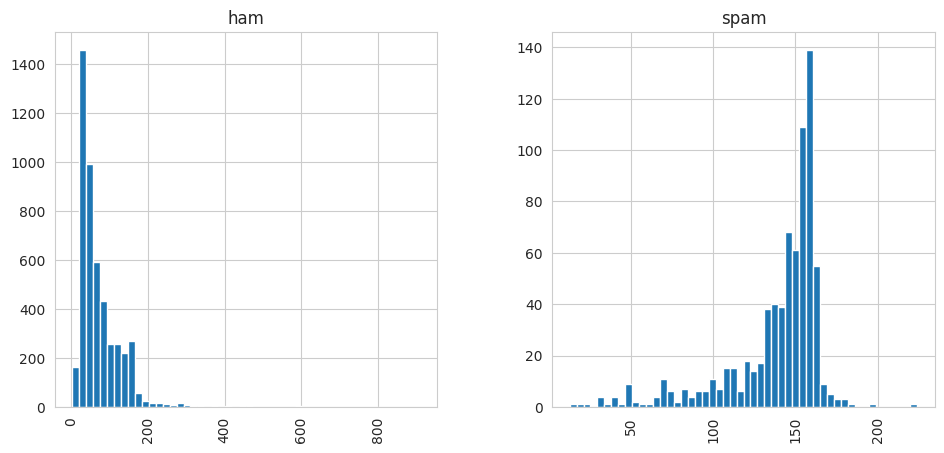

In [ ]:
mpl.rcParams['patch.force_edgecolor'] = True
#plt.style.use('seaborn-bright') ###
sns.set_style('whitegrid')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [ ]:
text_feat = sms['message'].copy()

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [ ]:
def text_process(text):

    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]

    return " ".join(text)

In [ ]:
import nltk
nltk.download('stopwords') ###
text_feat = text_feat.apply(text_process)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
features = vectorizer.fit_transform(text_feat)

###  Classifiers and predictions

First of all let's split our features to test and train set

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [ ]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

In [ ]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [ ]:
def train_classifier(clf, feature_train, labels_train):
    clf.fit(feature_train, labels_train)

In [ ]:
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [ ]:
pred_scores = []
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred)]))
    pred_dict[k]=[accuracy_score(labels_test,pred)]

In [ ]:
df = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score'])
df

,Score
SVC,0.978469
KN,0.924641
NB,0.984450
DT,0.958732
LR,0.943182
RF,0.970096
AdaBoost,0.933014
BgC,0.966507
ETC,0.977273


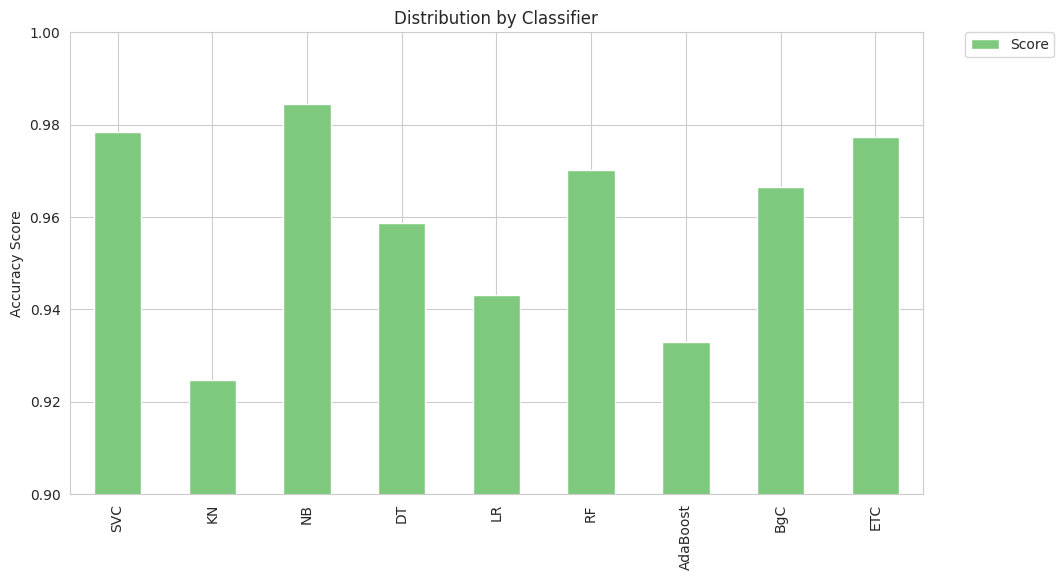

In [ ]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like ensemble classifiers are not doing as good as expected.

### Stemmer

Define our stemmer function

In [ ]:
def stemmer (text):
    text = text.split()
    words = ""
    for i in text:
            stemmer = SnowballStemmer("english")
            words += (stemmer.stem(i))+" "
    return words

In [ ]:
text_feat = text_feat.apply(stemmer)

In [ ]:
features = vectorizer.fit_transform(text_feat)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, sms['label'], test_size=0.3, random_state=111)

In [ ]:
pred_dict={}
for k,v in clfs.items():
    train_classifier(v, features_train, labels_train)
    pred = predict_labels(v,features_test)
    pred_dict[k]=[accuracy_score(labels_test,pred)]

In [ ]:
df2 = pd.DataFrame.from_dict(pred_dict,orient='index', columns=['Score2'])
df = pd.concat([df,df2],axis=1)
df

,Score,Score2
SVC,0.978469,0.978469
KN,0.924641,0.928230
NB,0.984450,0.985048
DT,0.958732,0.959928
LR,0.943182,0.946770
RF,0.970096,0.974880
AdaBoost,0.933014,0.934809
BgC,0.966507,0.968900
ETC,0.977273,0.977871


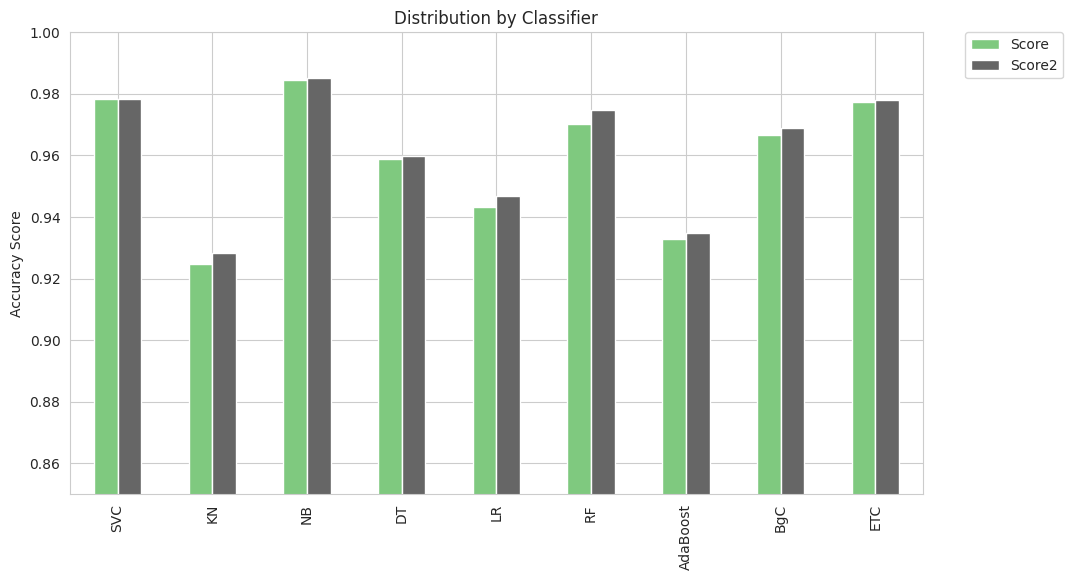

In [ ]:
df.plot(kind='bar', ylim=(0.85,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like mostly the same . Ensemble classifiers doing a little bit better, NB still got the lead.

### Voting classifier

We are using ensemble algorithms here, but what about ensemble of ensembles? Will it beat NB?

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [ ]:
eclf.fit(features_train,labels_train)

VotingClassifier(estimators=[('BgC',
                              BaggingClassifier(n_estimators=9,
                                                random_state=111)),
                             ('ETC',
                              ExtraTreesClassifier(n_estimators=9,
                                                   random_state=111)),
                             ('RF',
                              RandomForestClassifier(n_estimators=31,
                                                     random_state=111)),
                             ('Ada',
                              AdaBoostClassifier(n_estimators=62,
                                                 random_state=111))],
                 voting='soft')

In [ ]:
pred = eclf.predict(features_test)

In [ ]:
print(accuracy_score(labels_test,pred))

0.9784688995215312


Better but nope.

### Final verdict - well tuned NaiveBayes is your friend in spam detection.